In [ ]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_openai langgraph_sdk

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

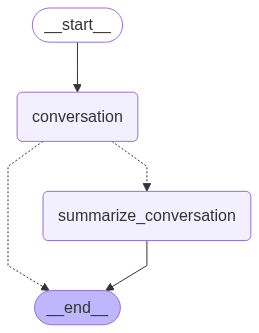

In [46]:
from IPython.display import display, Image
from typing import Literal

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

class State(MessagesState):
    summary: str

def call_model(state: State) -> State:
    summary = state.get("summary", "")

    if summary:
        system_messages = f"This is the summary of the conversation so far: {summary}"
        messages = [SystemMessage(content=system_messages)] + state["messages"]
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State) -> State:
    summary = state.get("summary", "")

    if summary:
        next_message = [HumanMessage(content=f"This is summary of the conversation so far extend this summary using the above messages: {summary}")]
        messages = state["messages"] + next_message
    else:
        messages = state["messages"] + [HumanMessage(content="Summarize the whole conversation so far without missing important details:")]

    response = model.invoke(messages)
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return {"messages": delete_messages, "summary": response.content}

def should_continue(state: State) -> Literal["summarize_conversation", "__end__"]:
    messages = state["messages"]

    if len(messages) > 6:
        return "summarize_conversation"

    return "__end__"


builder = StateGraph(State)
builder.add_node("conversation", call_model)
builder.add_node(summarize_conversation)
builder.add_edge(START, "conversation")
builder.add_conditional_edges("conversation", should_continue)
builder.add_edge("summarize_conversation", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [47]:
config = {"configurable": {"thread_id": "1"}}

for chunk in graph.stream({"messages": [HumanMessage(content="Hello This is Swaraj")]}, config=config, stream_mode="updates"):
    print(chunk)

{'conversation': {'messages': AIMessage(content='Hello Swaraj! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 12, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'id': 'chatcmpl-Bb584fqAhotl22jctw0EkwruiPRVo', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--632af1d8-a8f3-41b9-a3bd-311d8fc1eab9-0', usage_metadata={'input_tokens': 12, 'output_tokens': 11, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}}


In [48]:
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Swaraj")]}, config, stream_mode="updates"):
    chunk['conversation']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Swaraj! How are you doing today?


In [50]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Lance
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Lance
================================== Ai Message ==================================

Hello, Lance! How can I assist you today?
---------------------------------------------------------------------------


In [52]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me a little about machine learning.")
async for event in graph.astream_events(input={"messages": [input_message]}, config=config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node', '')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: conversation. Type: on_chain_start. Name: conversation
Node: conversation. Type: on_chat_model_start. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. Name: ChatOpenAI
Node: conversation. Type: on_chat_model_stream. N

In [54]:
node_to_stream = 'conversation'
config = {'configurable': {'thread_id': '1'}}
input_message = HumanMessage(content="Tell me a little about machine learning.")
async for event in graph.astream_events(input={"messages": [input_message]}, config=config, version="v2"):
    if event['event'] == "on_chat_model_stream" and event['metadata'].get('langgraph_node', '') == node_to_stream:
        print(event['data'])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--526c121c-1657-4ec5-8a15-cced9dec1130')}
{'chunk': AIMessageChunk(content='Machine', additional_kwargs={}, response_metadata={}, id='run--526c121c-1657-4ec5-8a15-cced9dec1130')}
{'chunk': AIMessageChunk(content=' learning', additional_kwargs={}, response_metadata={}, id='run--526c121c-1657-4ec5-8a15-cced9dec1130')}
{'chunk': AIMessageChunk(content=' is', additional_kwargs={}, response_metadata={}, id='run--526c121c-1657-4ec5-8a15-cced9dec1130')}
{'chunk': AIMessageChunk(content=' a', additional_kwargs={}, response_metadata={}, id='run--526c121c-1657-4ec5-8a15-cced9dec1130')}
{'chunk': AIMessageChunk(content=' branch', additional_kwargs={}, response_metadata={}, id='run--526c121c-1657-4ec5-8a15-cced9dec1130')}
{'chunk': AIMessageChunk(content=' of', additional_kwargs={}, response_metadata={}, id='run--526c121c-1657-4ec5-8a15-cced9dec1130')}
{'chunk': AIMessageChunk(content=' artificial', additional_

In [55]:
node_to_stream = 'conversation'
config = {'configurable': {'thread_id': '1'}}
input_message = HumanMessage(content="Tell me a little about machine learning.")
async for event in graph.astream_events(input={"messages": [input_message]}, config=config, version="v2"):
    if event['event'] == "on_chat_model_stream" and event['metadata'].get('langgraph_node', '') == node_to_stream:
        print(event['data']['chunk'].content)


Machine
 learning
 is
 a
 subset
 of
 artificial
 intelligence
 that
 focuses
 on
 developing
 algorithms
 and
 statistical
 models
 that
 enable
 computers
 to
 perform
 tasks
 without
 explicit
 instructions
.
 Instead
,
 these
 systems
 learn
 from
 data
 and
 improve
 their
 performance
 over
 time
.
 Here
 are
 some
 key
 points
 about
 machine
 learning
:


1
.
 **
Core
 Idea
**
:
 Machine
 learning
 involves
 training
 models
 on
 data
 to
 recognize
 patterns
,
 make
 predictions
,
 or
 take
 actions
 based
 on
 new
 inputs
.
 The
 goal
 is
 to
 enable
 computers
 to
 learn
 from
 experience
 and
 adapt
 to
 new
 situations
.


2
.
 **
Types
 of
 Machine
 Learning
**
:

  
 -
 **
Super
vised
 Learning
**
:
 Models
 are
 trained
 on
 labeled
 data
,
 meaning
 each
 training
 example
 is
 paired
 with
 an
 output
 label
.
 The
 model
 learns
 to
 map
 inputs
 to
 the
 correct
 outputs
.
 Common
 tasks
 include
 classification
 and
 regression
.

  
 -
 **
Un
super
vised
 Learnin

In [56]:
node_to_stream = 'conversation'
config = {'configurable': {'thread_id': '1'}}
input_message = HumanMessage(content="Tell me a little about machine learning.")
async for event in graph.astream_events(input={"messages": [input_message]}, config=config, version="v2"):
    if event['event'] == "on_chat_model_stream" and event['metadata'].get('langgraph_node', '') == node_to_stream:
        print(event['data']['chunk'].content, end='')

Machine learning is a field of artificial intelligence that focuses on developing algorithms and models that allow computers to learn from and make predictions or decisions based on data. Here are some key aspects of machine learning:

1. **Core Concept**: The primary goal of machine learning is to enable computers to learn from experience without being explicitly programmed for specific tasks. This involves identifying patterns in data and using these patterns to make predictions or decisions.

2. **Types of Machine Learning**:
   - **Supervised Learning**: Involves training a model on a labeled dataset, where each input is paired with the correct output. The model learns to predict the output from new inputs. Examples include spam detection and house price prediction.
   - **Unsupervised Learning**: The model is given data without explicit labels and must find patterns or structures within the data. Common tasks include clustering and dimensionality reduction.
   - **Reinforcement Le

In [60]:
from langgraph_sdk import get_client

URL = "http://127.0.0.1:2024"
client = get_client(url=URL)

assistants = await client.assistants.search()

In [61]:
assistants

[{'assistant_id': '6f6fce9a-b777-529d-9699-dd340ddec86c',
  'graph_id': 'dynamic_breakpoints',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'dynamic_breakpoints',
  'created_at': '2025-05-25T13:10:51.548011+00:00',
  'updated_at': '2025-05-25T13:10:51.548011+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca',
  'graph_id': 'agent',
  'config': {},
  'metadata': {'created_by': 'system'},
  'name': 'agent',
  'created_at': '2025-05-25T13:10:51.542586+00:00',
  'updated_at': '2025-05-25T13:10:51.542586+00:00',
  'version': 1,
  'description': None}]

In [65]:
thread = await client.threads.create() # create a new thread by default ,langgraph_sdk feature
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread_id=thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    print(event)

StreamPart(event='metadata', data={'run_id': '1f0396aa-f61f-653b-ae43-5e9d3ed78f84', 'attempt': 1})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '02f54c13-4e83-4a7c-93a5-677118454a11', 'example': False}]})
StreamPart(event='values', data={'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': '02f54c13-4e83-4a7c-93a5-677118454a11', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'id': 'call_XKSYqbjjio3c3hlYjzWzF8QE', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, 'response_metadata': {'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_

In [66]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create() # create a new thread by default ,langgraph_sdk feature
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread_id=thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="values"):
    messages = event.data.get('messages',None)
    if messages:
        print(convert_to_messages(messages)[-1])
    print('='*25)

content='Multiply 2 and 3' additional_kwargs={} response_metadata={} id='231d38d8-1c2d-4953-91b4-e594e5f79ff5'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 134, 'output_tokens': 17, 'total_tokens': 151, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_e0bCAa0K7NCjQApPt6kbhdSr', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 134, 'total_tokens': 151, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-Bb5XuSZJIyOLxDWBYotZ6cxxp2yf2', 'service_tier': 'default', 'finish_reason': 'tool_cal

In [67]:
from langchain_core.messages import convert_to_messages
thread = await client.threads.create() # create a new thread by default ,langgraph_sdk feature
input_message = HumanMessage(content="Multiply 2 and 3")
async for event in client.runs.stream(thread_id=thread["thread_id"], assistant_id="agent", input={"messages": [input_message]}, stream_mode="messages"):
    print(event.event)

metadata
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/metadata
messages/complete
messages/metadata
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial
messages/partial


In [68]:
thread = await client.threads.create()
input_message = HumanMessage(content="Multiply 2 and 3")

In [70]:
def format_tool_calls(tools_calls):
    if tools_calls:
        formatted_calls = []
        for call in tools_calls:
            formatted_calls.append(
                f"Tool Call ID: {call['id']}, Function: {call['name']}, Arguments: {call['args']}"
            )
        return "\n".join(formatted_calls)
    return "No tools calls"

In [71]:
async for event in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input={"messages": [input_message]},
    stream_mode="messages",):
    
    # Handle metadata events
    if event.event == "metadata":
        print(f"Metadata: Run ID - {event.data['run_id']}")
        print("-" * 50)
    
    # Handle partial message events
    elif event.event == "messages/partial":
        for data_item in event.data:
            # Process user messages
            if "role" in data_item and data_item["role"] == "user":
                print(f"Human: {data_item['content']}")
            else:
                # Extract relevant data from the event
                tool_calls = data_item.get("tool_calls", [])
                invalid_tool_calls = data_item.get("invalid_tool_calls", [])
                content = data_item.get("content", "")
                response_metadata = data_item.get("response_metadata", {})

                if content:
                    print(f"AI: {content}")

                if tool_calls:
                    print("Tool Calls:")
                    print(format_tool_calls(tool_calls))

                if invalid_tool_calls:
                    print("Invalid Tool Calls:")
                    print(format_tool_calls(invalid_tool_calls))

                if response_metadata:
                    finish_reason = response_metadata.get("finish_reason", "N/A")
                    print(f"Response Metadata: Finish Reason - {finish_reason}")
                    
        print("-" * 50)

Metadata: Run ID - 1f0396c1-4551-68ce-ba1a-a874d7cca9bc
--------------------------------------------------
Tool Calls:
Tool Call ID: call_Oubeeo0tX7KrS2lQQytxrq6x, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_Oubeeo0tX7KrS2lQQytxrq6x, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_Oubeeo0tX7KrS2lQQytxrq6x, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_Oubeeo0tX7KrS2lQQytxrq6x, Function: multiply, Arguments: {}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_Oubeeo0tX7KrS2lQQytxrq6x, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: call_Oubeeo0tX7KrS2lQQytxrq6x, Function: multiply, Arguments: {'a': 2}
--------------------------------------------------
Tool Calls:
Tool Call ID: cal